# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeting what are arguably the two hottest areas for real estate at the moment in NYC: **Hudson Yards** Neighborhood and '**Billionaires Row.**'

Since there are lots of restaurants in those areas we will try to detect **under represented cuisines**. We are also interested in **restaurants with a low rating by customers**. If we can combine those two to find an area of opportunity, we'll have a better chance of success with our own restaurant versus starting a restaurant with a cuisine that is over-represented and/or those that enjoy high customer satisfaction. 


## Data <a name="data"></a>

Following data sources will be needed to extract/generate the required information:
* One is a free data source from **NYU Spatial Data Repository** -https://geo.nyu.edu/catalog/nyu_2451_34572. The neighborhood locations will be obtained from here.
* Number of restaurants, their type, location and rating will be obtained using **Foursquare API** and **Zomato.**

In [49]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Download and Explore Dataset

In order to segment the neighborhoods and explore them, we will need a dataset that contains Manhattan as well as the the latitude and longitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web, here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [50]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [51]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [52]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

# Methodology <a name="methodology"></a>

The NYU data source contains location information for all 5 NYC boroughs and 306 neighborhoods. Since we already know which neighborhoods we want to focus on we can simplify our data source from here.

The area known as 'Billionaires Row' isn't a neighborhood per se but an area mainly concentrated along 57th St. between 8th ave. and Park ave. Carnegie Hall sits conveniently along 57th st, so we'll use its location to derive restaurants in that area.

Tranform the data into a pandas dataframe

In [53]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [54]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [55]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [56]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


We don't need all 5 boroughs, only Manhattan borough and **Hudson Yards** neighborhood.

In [57]:
manhattan_data = neighborhoods[(neighborhoods.Borough == 'Manhattan') & (neighborhoods.Neighborhood == 'Hudson Yards')].reset_index(drop=True)
manhattan_data

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Hudson Yards,40.756658,-74.000111


#### **Billionaires Row** (Carnegie Hall) coordinates

In [58]:
# Geocoding - Address to lat/long
g = Nominatim()
n = g.geocode('Carnegie Hall New York', timeout=10) # Address to geocode
print(n.latitude, n.longitude)

40.76503 -73.9798868158842


In [59]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Add both locations to Manhattan map.

In [60]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=13)
    
# add Hudson Yards marker to map
folium.Marker(
    location=[40.756658, -74.000111],
    popup='Hudson Yards',
    icon=folium.Icon(icon='info-sign')
).add_to(map_manhattan) 
    
# add Carnegie Hall marker to map
folium.Marker(
    location=[n.latitude, n.longitude],
    popup='Carnegie Hall',
    icon=folium.Icon(icon='info-sign')
).add_to(map_manhattan)          
    
map_manhattan

### Hudson Yards

Hudson Yards is New York’s newest neighborhood and home to more than 100 diverse shops and culinary experiences, offices for leaders in industry, significant public art and dynamic cultural institutions including The Shed, modern residences, 14 acres of public plazas, gardens and groves and the world’s first Equinox Hotel®. <a>https://www.hudsonyardsnewyork.com/about</a>

### Billionaires Row

Billionaires' Row is the name given to a set of ultra-luxury residential skyscrapers, constructed or in development, that are arrayed roughly along the southern end of Central Park in Manhattan, New York City. Several of these buildings are in the supertall category (taller than 1,000 feet (300 m)), and are among the tallest buildings in the world. Since most of these buildings are built or proposed on 57th Street, the term has been used to refer to the street itself as well. The area is notable for containing some of the most expensive residences in the world. <a>https://en.wikipedia.org/wiki/Billionaires%27_Row_(Manhattan)</a>

### Define Foursquare Credentials and Version

In [61]:
CLIENT_ID = 'CPD13XS2VENH3MNKWUAVUO1JIZZGPHD1GNMDNNSNTYMS0BWE' # your Foursquare ID
CLIENT_SECRET = 'LSPXZWFNRBEBQ044DSZ4BMJFMKBITLS1VA44ZX4OTSCP1KFR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CPD13XS2VENH3MNKWUAVUO1JIZZGPHD1GNMDNNSNTYMS0BWE
CLIENT_SECRET:LSPXZWFNRBEBQ044DSZ4BMJFMKBITLS1VA44ZX4OTSCP1KFR


In [62]:
manhattan_data.loc[0, 'Neighborhood']

'Hudson Yards'

In [63]:
hudson_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
hudson_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

hudson_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(hudson_name, 
                                                               hudson_latitude, 
                                                               hudson_longitude))

Latitude and longitude values of Hudson Yards are 40.75665808227519, -74.00011136202637.


#### Let's get the top 100 restaurant venues that are within a radius of 500 meters of Hudson Yards.

In [64]:
radius = 500
LIMIT = 100
query = 'restaurant'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    hudson_latitude, 
    hudson_longitude,
    query,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=CPD13XS2VENH3MNKWUAVUO1JIZZGPHD1GNMDNNSNTYMS0BWE&client_secret=LSPXZWFNRBEBQ044DSZ4BMJFMKBITLS1VA44ZX4OTSCP1KFR&v=20180605&ll=40.75665808227519,-74.00011136202637&query=restaurant&radius=500&limit=100'

In [65]:
hudson_results = requests.get(url).json()
hudson_results;

#### Let's get the top 100 restaurant venues that are within a radius of 500 meters of Carnegie Hall.

In [67]:
carnegie_latitude = n.latitude # neighborhood latitude value
carnegie_longitude = n.longitude # neighborhood longitude value

carnegie_name = n # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(carnegie_name, 
                                                               carnegie_latitude, 
                                                               carnegie_longitude))

Latitude and longitude values of Carnegie Hall, West 56th Street, 5th Ave Retail Corridor N, Midtown, Manhattan Community Board 5, Manhattan, New York County, NYC, New York, 10019, USA are 40.76503, -73.9798868158842.


In [68]:
radius = 500
LIMIT = 100
query = 'restaurant'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    carnegie_latitude, 
    carnegie_longitude,
    query,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=CPD13XS2VENH3MNKWUAVUO1JIZZGPHD1GNMDNNSNTYMS0BWE&client_secret=LSPXZWFNRBEBQ044DSZ4BMJFMKBITLS1VA44ZX4OTSCP1KFR&v=20180605&ll=40.76503,-73.9798868158842&query=restaurant&radius=500&limit=100'

In [69]:
carnegie_results = requests.get(url).json()
carnegie_results;

# Analysis<a name="analysis"></a>

Tranform the Carnegie Hall (Billionaires Row) data into a pandas dataframe

In [70]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [71]:
venues = carnegie_results['response']['groups'][0]['items']
    
carnegie_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
carnegie_nearby_venues = carnegie_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
carnegie_nearby_venues['venue.categories'] = carnegie_nearby_venues.apply(get_category_type, axis=1)

# clean columns
carnegie_nearby_venues.columns = [col.split(".")[-1] for col in carnegie_nearby_venues.columns]

carnegie_nearby_venues.head()

,name,categories,lat,lng
0,Estiatorio Milos,Greek Restaurant,40.763386,-73.979204
1,Indian Accent,North Indian Restaurant,40.764127,-73.978787
2,Souvlaki GR,Souvlaki Shop,40.764600,-73.980194
3,La Esquina,Taco Place,40.764417,-73.981440
4,The Halal Guys,Halal Restaurant,40.763826,-73.980182


### **Billionaires Row** area restaurants

#### Breakdown of restaurants by category.

In [72]:
carnegie_nearby_venues.groupby(['categories']).count()

,name,lat,lng
categories,,,
American Restaurant,7,7,7
Bakery,4,4,4
Breakfast Spot,1,1,1
Burger Joint,4,4,4
Café,2,2,2
Chinese Restaurant,1,1,1
Cuban Restaurant,3,3,3
Deli / Bodega,6,6,6
Donut Shop,1,1,1


### **Hudson Yards** area restaurants

In [73]:
venues = hudson_results['response']['groups'][0]['items']
    
hudson_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
hudson_nearby_venues = hudson_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
hudson_nearby_venues['venue.categories'] = hudson_nearby_venues.apply(get_category_type, axis=1)

# clean columns
hudson_nearby_venues.columns = [col.split(".")[-1] for col in hudson_nearby_venues.columns]

hudson_nearby_venues.head()

,name,categories,lat,lng
0,Friedman's,American Restaurant,40.755271,-73.998509
1,Kawi,Asian Restaurant,40.753913,-74.001322
2,Hudson Yards Grill,American Restaurant,40.754068,-74.000544
3,Legacy Records,American Restaurant,40.757592,-73.998352
4,Chef's Table At Brooklyn Fare,American Restaurant,40.756024,-73.996366


#### Breakdown of restaurants by category

In [74]:
hudson_nearby_venues.groupby(['categories']).count()

,name,lat,lng
categories,,,
American Restaurant,5,5,5
Asian Restaurant,1,1,1
BBQ Joint,1,1,1
Bakery,1,1,1
Burger Joint,1,1,1
Café,6,6,6
Caucasian Restaurant,1,1,1
Chinese Restaurant,1,1,1
Deli / Bodega,2,2,2


## __Restaurants by Neighborhood__

In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Neighborhood clusters
from folium import plugins
incidents = plugins.MarkerCluster().add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, in zip(carnegie_nearby_venues['lat'], carnegie_nearby_venues['lng'], carnegie_nearby_venues['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        popup=label,
        fill_color='blue',
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi, in zip(hudson_nearby_venues['lat'], hudson_nearby_venues['lng'], hudson_nearby_venues['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)    
       
map_clusters

### Both neighborhood restaurant category charts sorted alphabetically to compare and visualize them more easily together

In [76]:
carnegie_nearby_venues2 = carnegie_nearby_venues.sort_values(by=['categories'], inplace=False, ascending=True)
hudson_nearby_venues2 = hudson_nearby_venues.sort_values(by=['categories'], inplace=False, ascending=True)

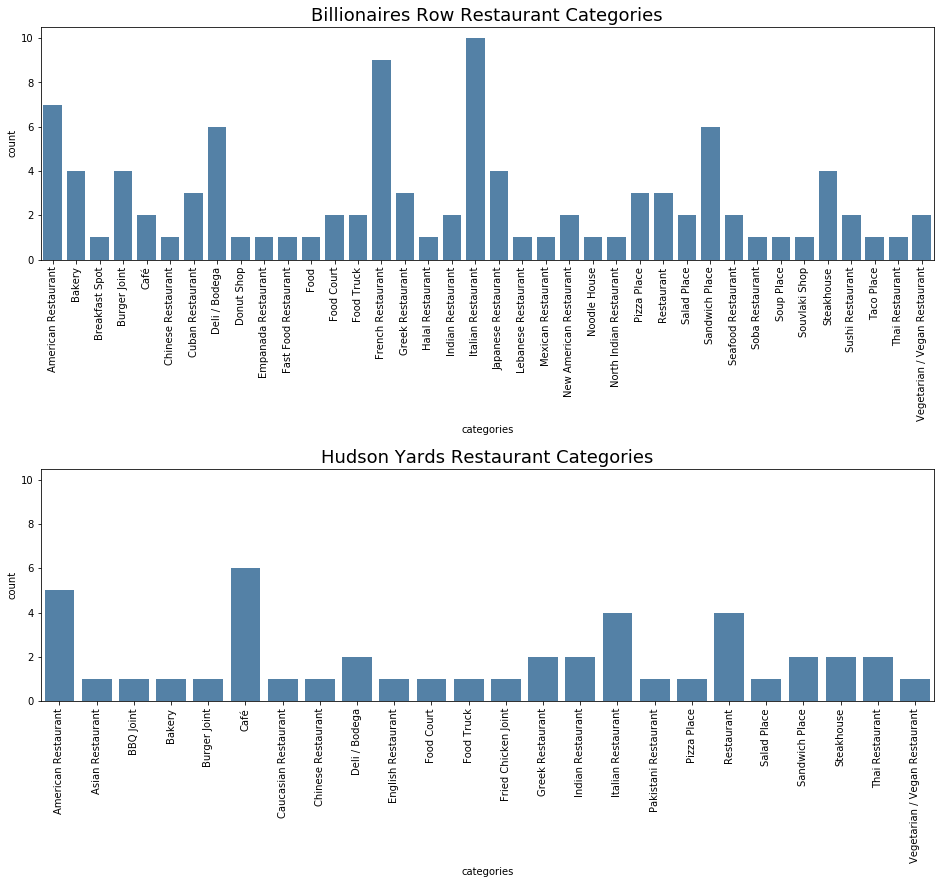

In [77]:
# Initialize the figure
count, (ax1, ax2) = plt.subplots(2,1, sharey=True,  figsize=(16, 12))
plt.subplots_adjust(bottom=0.1, hspace=0.9)

# Load dataset
ax1 = sns.countplot(x='categories', color='steelblue', ax=ax1, data=carnegie_nearby_venues2)
ax2 = sns.countplot(x='categories', color='steelblue', ax=ax2, data=hudson_nearby_venues2)

# Add informative axis label
ax1.set_title('Billionaires Row Restaurant Categories', fontsize=18)
ax2.set_title('Hudson Yards Restaurant Categories', fontsize=18)
plt.xticks(rotation=90)
rotation = 90 
for i, ax in enumerate(carnegie_nearby_venues):
     ax1.set_xticklabels(ax1.get_xticklabels(), rotation = rotation)

plt.show()

This is pretty good but not all categories match up, also we just need to concentrate on those categories that have the least representation, so let's change the sort order by count instead. Plus, we can make a Pareto chart for fun.

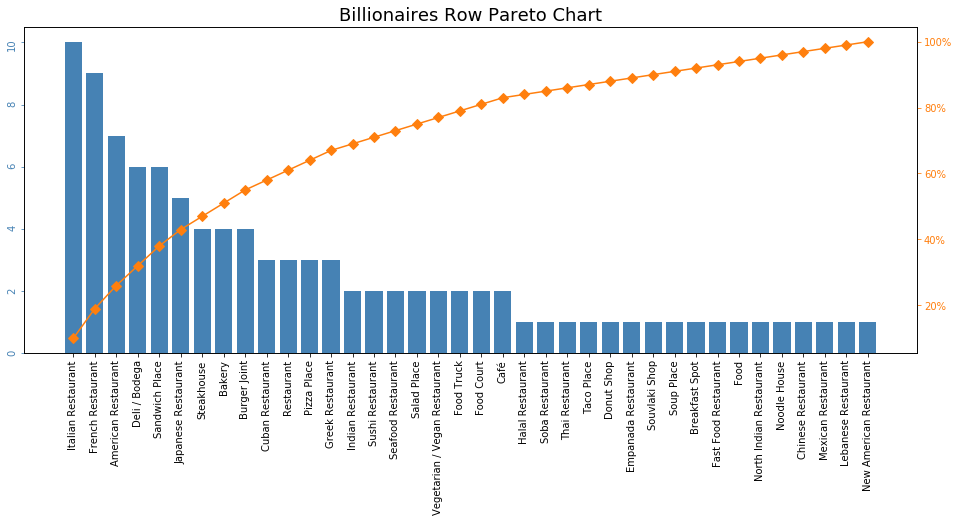

In [78]:
df = pd.DataFrame({'count': [7,4,1,4,2,1,3,6,1,1,1,1,2,2,9,3,1,2,10,5,1,1,1,1,1,3,3,2,6,2,1,1,1,4,2,1,1,2]})
df.index = ['American Restaurant','Bakery','Breakfast Spot','Burger Joint','Café','Chinese Restaurant','Cuban Restaurant','Deli / Bodega','Donut Shop','Empanada Restaurant','Fast Food Restaurant','Food','Food Court','Food Truck','French Restaurant','Greek Restaurant','Halal Restaurant','Indian Restaurant','Italian Restaurant','Japanese Restaurant','Lebanese Restaurant','Mexican Restaurant','New American Restaurant','Noodle House','North Indian Restaurant','Pizza Place','Restaurant','Salad Place','Sandwich Place','Seafood Restaurant','Soba Restaurant','Soup Place','Souvlaki Shop','Steakhouse','Sushi Restaurant','Taco Place','Thai Restaurant','Vegetarian / Vegan Restaurant']
df = df.sort_values(by='count',ascending=False)
df["cumpercentage"] = df["count"].cumsum()/df["count"].sum()*100

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(df.index, df["count"], color="steelblue")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.set_title('Billionaires Row Pareto Chart', fontsize=18)
ax.tick_params(labelrotation=90)
ax.tick_params(axis="y", colors="steelblue")
ax2.tick_params(axis="y", colors="C1")
plt.show()

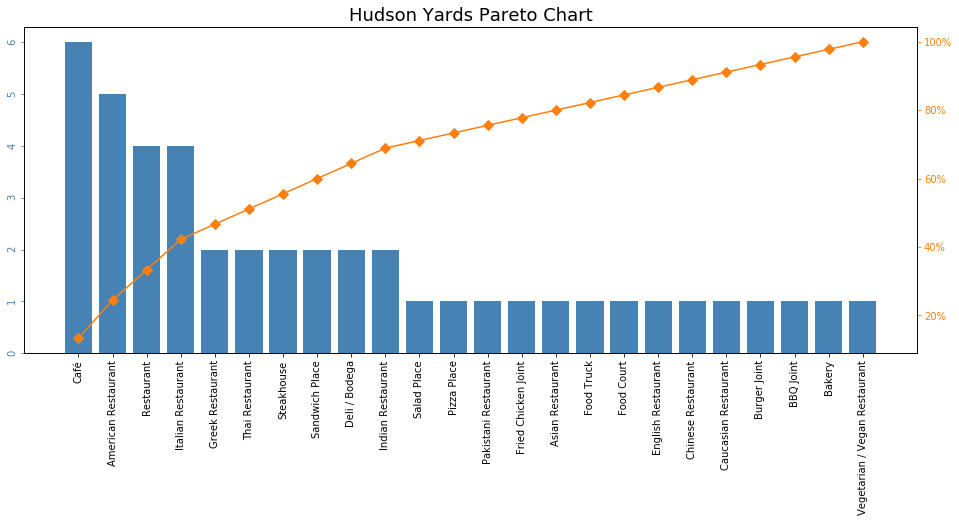

In [79]:
df_hy = pd.DataFrame({'count': [5,1,1,1,1,6,1,1,2,1,1,1,1,2,2,4,1,1,4,1,2,2,2,1]})
df_hy.index = ['American Restaurant','Asian Restaurant','Bakery','BBQ Joint','Burger Joint','Café','Caucasian Restaurant','Chinese Restaurant','Deli / Bodega','English Restaurant','Food Court','Food Truck','Fried Chicken Joint','Greek Restaurant','Indian Restaurant','Italian Restaurant','Pakistani Restaurant','Pizza Place','Restaurant','Salad Place','Sandwich Place','Steakhouse','Thai Restaurant','Vegetarian / Vegan Restaurant']
df_hy = df_hy.sort_values(by='count',ascending=False)
df_hy["cumpercentage"] = df_hy["count"].cumsum()/df_hy["count"].sum()*100

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(df_hy.index, df_hy["count"], color="steelblue")
ax2 = ax.twinx()
ax2.plot(df_hy.index, df_hy["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.set_title('Hudson Yards Pareto Chart', fontsize=18)
ax.tick_params(labelrotation=90)
ax.tick_params(axis="y", colors="steelblue")
ax2.tick_params(axis="y", colors="C1")
plt.show()

So, for both charts we'll make a new dataframe to focus on only those categories with a count of one. I didn't include some categories e.g. Food, Food Truck, Food Court as these terms are too generic.

In [80]:
carnegie_sm_count = pd.DataFrame({'category': ['Hala Restaurant', 'Soba Restaurant', 'Thai Restaurant', 'Taco Place', 'Donut Shop', 'Empanada Restaurant', 'Souvlaki Shop', 'Soup Place', 'Breakfast Spot', 'Fast Food Restaurant', 'North Indian Restaurant', 'Noodle House', 'Chinese Restaurant', 'Mexican Restaurant', 'Lebanese Restaurant', 'New American Restaurant']})

hudson_sm_count = pd.DataFrame({'category': ['Salad Place', 'Pizza Place', 'Pakistani Restaurant', 'Fried Chicken Joint', 'Asian Restaurant', 'English Restaurant', 'Chinese Restaurant', 'Caucasian Restaurant', 'Burger Joint', 'BBQ Joint', 'Bakery', 'Vegetarian/Vegan Restaurant']})

### Get the venue's overall rating

Unfortunately, Foursquare is not very popular with consumers for rating restaurants. Only about 30% had ratings. Zomato is much better but their API requires a phone number and website URL, so I had to do things the old fashioned way. Input the data by hand.

In [81]:
venue_id = '5243134f11d2daa4bf660257' # ID of Indian Accent
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
         print(result['response']['venue']['rating'])
except:
         print('This venue has not been rated yet.')

This venue has not been rated yet.


In [82]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
result = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### **Billionaires Row** restaurant ratings

In [83]:
venues = carnegie_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.id']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# add rating column
from numpy import nan
nearby_venues = nearby_venues.assign(rating = [4.3,4.9,2.9,np.NaN,4.9,3.7,4.4,4.4,3.4,4.8,4.1,np.NaN,3.7,np.NaN,3.4,np.NaN,4.5,4.4,3.9,np.NaN,4.1,4.1,3.9,np.NaN,4.2,4.3,4.2,np.NaN,4.2,4.3,np.NaN,np.NaN,3.4,np.NaN,3.5,np.NaN,4.3,np.NaN,np.NaN,np.NaN,np.NaN,4.4,3.8,3.8,3.7,np.NaN,3.7,4.0,4.1,4.1,3.8,np.NaN,4.3,3.2,3.4,3.4,3.7,4.4,3.5,3.1,3.5,4.1,3.9,4.0,np.NaN,4.4,3.7,3.2,4.2,4.4,3.9,4.8,4.8,3.9,np.NaN,np.NaN,4.1,np.NaN,np.NaN,4.0,np.NaN,4.7,3.4,4.4,4.4,4.2,4.0,4.6,3.7,3.8,np.NaN,4.3,np.NaN,4.2,3.2,4.5,3.6,3.4,3.7,4.5])
nearby_venues.head()

,name,categories,id,rating
0,Estiatorio Milos,Greek Restaurant,3fd66200f964a520d7ea1ee3,4.3
1,Indian Accent,North Indian Restaurant,56c55e43cd105142e6f95b94,4.9
2,Souvlaki GR,Souvlaki Shop,56048f23498e16b72f056fd9,2.9
3,La Esquina,Taco Place,584ee230d8f3e90bf946d646,NaN
4,The Halal Guys,Halal Restaurant,4a19d1edf964a5205a7a1fe3,4.9


#### **Hudson Yards** restaurant ratings

### Billionaires Row descriptive statistics

We see that there are 38 unique restaurant categories and the average rating for all restaurants is 4.0 out of 5.0.

In [84]:
nearby_venues.describe(include='all')

,name,categories,id,rating
count,100,100,100,75.000000
unique,93,38,100,NaN
top,Pret A Manger,Italian Restaurant,544bdb05498e693acb03b289,NaN
freq,5,10,1,NaN
mean,NaN,NaN,NaN,4.001333
std,NaN,NaN,NaN,0.461049
min,NaN,NaN,NaN,2.900000
25%,NaN,NaN,NaN,3.700000
50%,NaN,NaN,NaN,4.100000
75%,NaN,NaN,NaN,4.350000


In [85]:
venues = hudson_results['response']['groups'][0]['items']
    
hy_nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.id']
hy_nearby_venues = hy_nearby_venues.loc[:, filtered_columns]

# filter the category for each row
hy_nearby_venues['venue.categories'] = hy_nearby_venues.apply(get_category_type, axis=1)

# clean columns
hy_nearby_venues.columns = [col.split(".")[-1] for col in hy_nearby_venues.columns]

# add rating column
hy_nearby_venues = hy_nearby_venues.assign(rating = [4.0,np.NaN,np.NaN,np.NaN,4.1,np.NaN,4.3,np.NaN,3.6,3.8,np.NaN,np.NaN,3.4,3.8,np.NaN,np.NaN,np.NaN,3.8,np.NaN,4.2,3.7,np.NaN,4.0,3.7,2.5,np.NaN,np.NaN,np.NaN,4.7,np.NaN,3.2,np.NaN,3.5,2.8,np.NaN,np.NaN,np.NaN,np.NaN,2.6,np.NaN,np.NaN,3.5,3.7,np.NaN,np.NaN]) 

hy_nearby_venues.head()

,name,categories,id,rating
0,Friedman's,American Restaurant,54ddf9a1498e766ab85781f4,4.0
1,Kawi,Asian Restaurant,5c8736c0178a2a002cf4adce,NaN
2,Hudson Yards Grill,American Restaurant,5c886442b04056002c8ced53,NaN
3,Legacy Records,American Restaurant,59f3554f002f4c0655d65bab,NaN
4,Chef's Table At Brooklyn Fare,American Restaurant,5854cfc203cf255eb3b9c8cb,4.1


### Hudson Yards descriptive statistics

24 unique restaurant categories here with an average of 3.6 out of 5.0 for all restaurants.

In [86]:
hy_nearby_venues.describe(include='all')

,name,categories,id,rating
count,45,45,45,20.000000
unique,44,24,45,NaN
top,Subway,Café,5b647af84aa3f8002cbffffc,NaN
freq,2,6,1,NaN
mean,NaN,NaN,NaN,3.645000
std,NaN,NaN,NaN,0.552959
min,NaN,NaN,NaN,2.500000
25%,NaN,NaN,NaN,3.475000
50%,NaN,NaN,NaN,3.700000
75%,NaN,NaN,NaN,4.000000


Here are the available ratings for all restaurant cateogories.

In [87]:
sorted_carnegie_venues = nearby_venues.sort_values(by=['categories'], inplace=False, ascending=True)
sorted_hudson_venues = hy_nearby_venues.sort_values(by=['categories'], inplace=False, ascending=True)

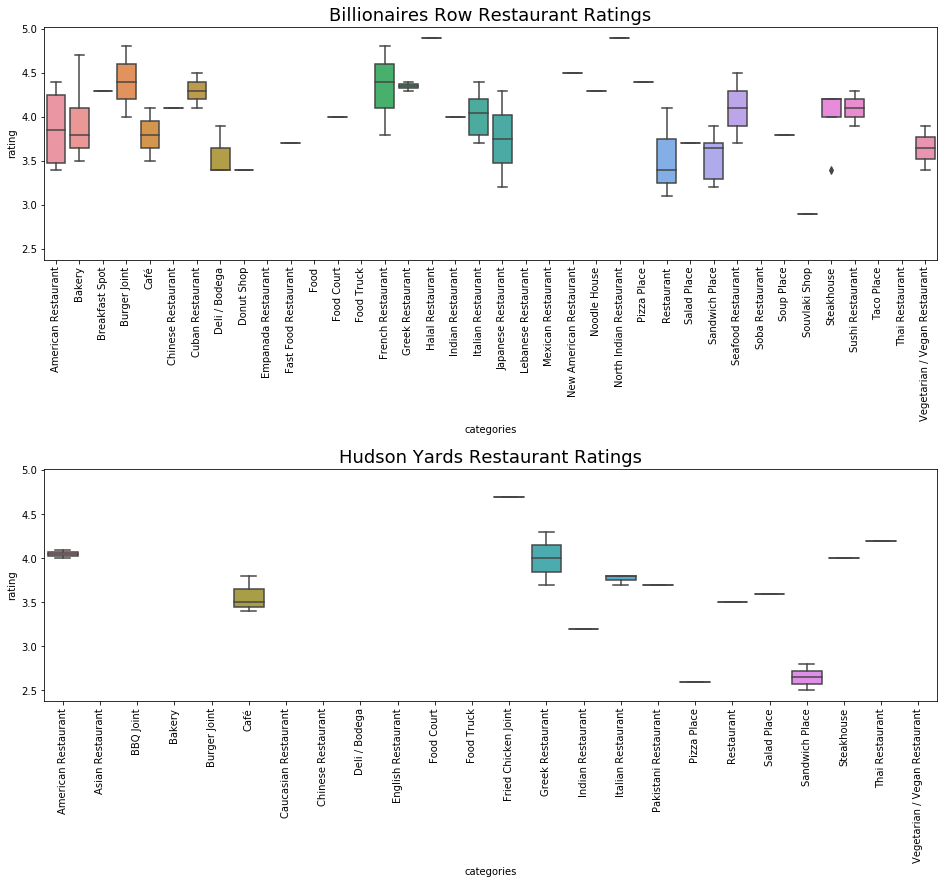

In [88]:
# Initialize the figure
count, (ax3, ax4) = plt.subplots(2,1, sharey=True, figsize=(16, 12))
plt.subplots_adjust(bottom=0.1, hspace=0.9)

# Load dataset
ax3 = sns.boxplot(x='categories', y='rating', ax=ax3, data=sorted_carnegie_venues)
ax4 = sns.boxplot(x='categories', y='rating', ax=ax4, data=sorted_hudson_venues)

# Add informative axis label
ax3.set_title('Billionaires Row Restaurant Ratings', fontsize=18)
ax4.set_title('Hudson Yards Restaurant Ratings', fontsize=18)
plt.xticks(rotation=90)
rotation = 90 
for i, ax in enumerate(carnegie_nearby_venues):
     ax3.set_xticklabels(ax1.get_xticklabels(), rotation = rotation)

plt.show()

From these we'll take only those that have ratings AND match our new smaller dataframe categories from earlier.

In [89]:
# Add rating column
carnegie_sm_count = carnegie_sm_count.assign(rating = [4.9,4.3,np.NaN,np.NaN,3.4,np.NaN,2.9,np.NaN,4.3,3.7,4.9,np.NaN,4.1,4.1,np.NaN,4.7]).sort_values(by='rating')
carnegie_sm_count

,category,rating
6,Souvlaki Shop,2.9
4,Donut Shop,3.4
9,Fast Food Restaurant,3.7
12,Chinese Restaurant,4.1
13,Mexican Restaurant,4.1
1,Soba Restaurant,4.3
8,Breakfast Spot,4.3
15,New American Restaurant,4.7
0,Hala Restaurant,4.9
10,North Indian Restaurant,4.9


In [90]:
# Add rating column
hudson_sm_count = hudson_sm_count.assign(rating = [3.6,2.6,3.7,4.7,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]).sort_values(by='rating')
hudson_sm_count

,category,rating
1,Pizza Place,2.6
0,Salad Place,3.6
2,Pakistani Restaurant,3.7
3,Fried Chicken Joint,4.7
4,Asian Restaurant,NaN
5,English Restaurant,NaN
6,Chinese Restaurant,NaN
7,Caucasian Restaurant,NaN
8,Burger Joint,NaN
9,BBQ Joint,NaN


Our analysis shows a large number of restaurant categories in both locations with ratings that span the gamut. the Hudson Yards project is brand new so the lack of ratings for some places can be justified by that fact. Our main focus was to narrow our search to those categories that are under-represented.

After directing our attention to this more narrow area of interest we then took a look at the categorical ratings and filtered those categories so those with only a single restaurant  representing that category were included in our results.

Result of all this for both neighborhood locations would be to focus on those categories receiving ratings under 4.0. As this would be prime to provide a quality restaurant in a category that has little competition and what competition there is has received low ratings from their patrons.

Those with no rating we would ignore as the number of reasons could be varied and outside the scope of this project. 


## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify under represented cuisine in two neighborhoods in NYC. Secondary was to identify which of those have low ratings. By using Foursquare data we identified restaurant categories, and used Zomato ratings to further analysis.

Final decision on restaurant location and cuisine type will require further research. As of now those cuisines with only one restaurant in their respective area are worthy of consideration. And those with two or more, and have high ratings, regardless of being under-represented we should not consider.